In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn

from sklearn.metrics import r2_score

from tqdm import tqdm

from pprint import pprint

from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("data/W22-anonymized_results-rows.csv", encoding="ANSI")

In [5]:
cols = [i for i in df.columns if "week" not in i]

In [6]:
df2 = df[cols]

In [8]:
df3 = df2.describe()

In [9]:
df3.to_csv("example.csv")

In [4]:
df.dropna(axis=1, how='all', inplace=True)

In [4]:
to_drop = [col for col in df.columns if "Percentage" in col or "Letter" in col]

In [5]:
df.drop(columns = to_drop, inplace=True)

In [6]:
df.drop(columns=[col for col in df.columns
                 if list(np.unique(df[col].astype(str))) == ["-"]],
        inplace=True)


In [7]:
df.fillna("None", inplace=True)

In [8]:
for col in df.columns:
    print("-", col)

- PA01 (Real)
- PA02 (Real)
- PA03 (Real)
- PA04 (Real)
- PA05 (Real)
- PA06 (Real)
- PA07 (Real)
- PA08 (Real)
- PA09 (Real)
- PA10 (Real)
- zyBook PAs total (Real)
- CA01 (Real)
- CA02 (Real)
- CA03 (Real)
- CA04 (Real)
- CA05 (Real)
- CA06 (Real)
- CA07 (Real)
- CA08 (Real)
- CA09 (Real)
- zyBook Challenge Activities (CAs) total (Real)
- Week 1 Lab breakout activity (Real)
- Week 2 Lab breakout activity (Real)
- Week 3 Lab breakout activity (Real)
- Week 4 Lab breakout activity (Real)
- Week 5 Lab breakout activity (Real)
- Week 6 Lab breakout activity (Real)
- Week 7 Lab breakout activity (Real)
- Week 8 Lab breakout activity (Real)
- Week 9 Lab breakout activity (Real)
- Wednesday lab participation total (Real)
- LA01 (Real)
- LA02 (Real)
- LA03 (Real)
- LA04 (Real)
- LA05 (Real)
- LA06 (Real)
- LA07 (Real)
- Week 8 Labs (Gradescope) (Real)
- Week 8 Labs (zyBook 8.16, 8.17) (Real)
- LA08 (combined) total (Real)
- LA09 (Real)
- zyBook Lab Activities (LAs) total (Real)
- Labs total 

In [9]:
text_columns = sorted([col for col in df.columns if "Last question" in col or "example/probl" in col])

In [107]:
XY = pd.DataFrame()
for col_n in range(0, len(text_columns), 2):
    XY[f"week{col_n//2 + 1}"] = df[text_columns[col_n]].astype(str).str.lower() + \
                                "[SEP]" + \
                               df[text_columns[col_n + 1]].astype(str).str.lower()

In [108]:
# Let's leave only thoose who answered on targtet questions at least 2 times
empty_reflections = XY[XY.apply(lambda x: sum(len(str(i)) < 15 for i in x) > 7, 1)].index.values

In [109]:
XY["Y"] = df["Course total (Real)"]

In [110]:
XY.drop(index=empty_reflections, inplace=True)

In [111]:
print(f"Size of data is {len(XY)}")

Size of data is 219


In [84]:
from transformers import AutoTokenizer, AutoModel

In [92]:
MODEL = 'sentence-transformers/bert-base-nli-mean-tokens'

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

In [114]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_768_features(text):
    if len(text) > 500:
        text = text[:500]
    encoded_input = tokenizer([text], return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings[0].detach().numpy()

In [115]:
for week_n in range(1,10):
    column = f"week{week_n}"
    XY[column + "_emb"] = XY[column].apply(get_768_features)
    
    print(f"{column} done")

week1 done
week2 done
week3 done
week4 done
week5 done
week6 done
week7 done
week8 done
week9 done


In [116]:
XY.drop(columns=[f"week{n}" for n in range(1,10)], inplace=True)

In [185]:
Y = XY["Y"].to_numpy()
X = XY.drop(columns=["Y"]).to_numpy()

In [186]:
# Crazy flattening and then combining array of array of array back to 3D array (pd, why?!)
X = np.array([[list(X[j,i]) for i in range(X.shape[1])] for j in range(X.shape[0])])

In [189]:
X.shape, Y.shape

((219, 9, 768), (219,))

In [429]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                  X, Y, test_size=0.15, random_state=42)

In [430]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float().unsqueeze(1).repeat(1, 9)

# Model

In [462]:
model = torch.nn.Sequential(
    torch.nn.LSTM(768, 128, batch_first=True),
    torch.nn.LeakyReLU(),
    torch.nn.LSTM(128, 32, batch_first=True),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid()
)

def forward(x):
    s1, _ = model[0](x)
    s2 = model[1](s1)
    s3, _ = model[2](s2)
    s4 = model[3](s3)
    s5 = model[4](s4)
    return model[5](s5) * 1000

model.forward = forward

In [463]:
def loss_function(x, y):
    coefs = torch.tensor([i * 0.1 for i in range(1,10)])
    return ((x - y).abs() * coefs).mean()

learning_rate = 1e-6 # ?
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [467]:
losses = []
r2s = []
order = [i for i in range(len(X_train))]
for epoch in tqdm(range(1000)): 
    np.random.shuffle(order)
    inputs = X_train[order].squeeze()
    targets = y_train[order].squeeze()
    for i in range(len(X_train)):  
        
        model.zero_grad()
        scores = model(inputs[i].unsqueeze(0))
        
        loss = loss_function(scores.squeeze(), targets[i])
        loss.backward()
        optimizer.step()
        losses += list(loss.detach().flatten())
        r2s.append(test())

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:48:35<00:00, 13.72s/it]


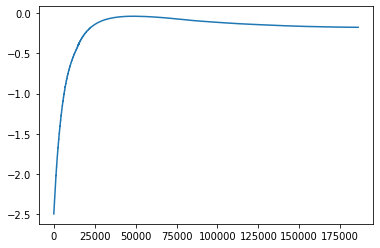

In [468]:
plt.plot(r2s)

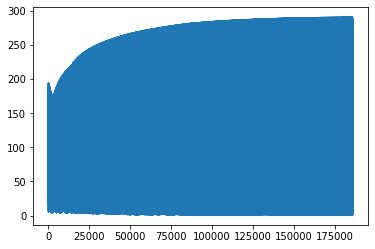

In [469]:
plt.plot(losses)

In [470]:
def test():
    results = torch.Tensor()
    with torch.no_grad():
        for i in range(len(X_test)):  

            model.zero_grad()
            scores = model(torch.from_numpy(X_test[i]).unsqueeze(0).float())
            results = torch.cat([results, scores.detach().flatten()])
    results = [float(i) for i in sum([list(i.detach().flatten()) for i in results],[])]
    y_test2 = sum([[i] * 9 for i in y_test], [])
    r2 = r2_score(y_test2, results)
    return r2

In [459]:
r2

-0.18334409074278524